# From workflow provenance to nanopublication summaries

This notebook provides an early prototype aimed at annotating workflow consumed/produced data with EDAM bioinformatics terms : 
1. Initial data loading
2. Associating PROV activities with tool names
3. Retrieving tools annotations from Bio.Tools
4. Building the Nanopub "assertion" graph
5. Generating a Nanopublication based on a template


## RDF / SPARQL helping code
RDFLib is used to manage RDF graphs

In [1]:
from IPython.display import display, Markdown, Latex
from rdflib import Graph, RDF, RDFS, Namespace
#from RDFClosure import DeductiveClosure, RDFS_Semantics

import requests
import json
import io
import jellyfish

g = Graph()

PROV = Namespace('http://www.w3.org/ns/prov#')
g.bind('prov',PROV)

#def infer():
#    DeductiveClosure(RDFS_Semantics, rdfs_closure = True, axiomatic_triples = False, datatype_axioms = False).expand(g)

def serialize():
    print(g.serialize(format='turtle'))

def save(filename):
    with open(filename, 'w') as f:
        g.serialize(f, format='turtle')
        
def load(filename):
    with io.open(filename,'r',encoding='utf8') as f:
        g.load(f, format='turtle')    
    
    

## 1. Initial data loading
- the domain-agnostic provenance graph [exome-provenance.ttl](files/exome-provenance.ttl) in PROV 
- the EDAM bioinformatics ontology [edam.owl](files/edam.owl)
- a bio.tools RDF dump [biotools-dump-latest.ttl](files/biotools-dump-latest.ttl) (from http://bio.tools) : a bioinformatics tools registry leveraging the EDAM ontology


In [2]:
load('exome-provenance.ttl')
print('exome-provenance.ttl loaded')
load('biotools-dump-latest.ttl')
print('biotools-dump-latest.ttl loaded')

with io.open('edam.owl','r',encoding='utf8') as f:
        g.load(f, format='xml')
print('edam.owl loaded')



exome-provenance.ttl loaded
biotools-dump-latest.ttl loaded
edam.owl loaded


In [3]:
print('Graph size: %s triples' % len(g))

Graph size: 187019 triples


## 2. Associating PROV activities with tool names

We get here a map with PROV activity URIs and the launch binaries. **We assume** that the first word of the command is the name of the tool. Obviously it won't fit complex command lines with multiple binaries and pipes `|` or semicolon `;`. 

We also retrieve the list of tool names without duplicates. In this example, **we have one false positive** namely `tr`. 

In [4]:
query = """
SELECT DISTINCT * WHERE {
    ?x rdf:type prov:Activity .
    ?x rdfs:comment ?command
}
"""
results = g.query(query)

tool_activities = {}
tool_names = []

for r in results:
    if r['command']:
        #print(r['command'].strip('\t').strip('\n').strip())
        toolname = r['command'].strip('\t').strip('\n').strip().partition(' ')[0]
        tool_activities[str(r['x'])] = toolname
        tool_names.append(toolname)

tool_names = list(set(tool_names))

display(Markdown("**List of activities:**"))
print(tool_activities)
print()
display(Markdown("**List of tool names:**"))
print(tool_names)

**List of activities:**

{'http://snakemake-provenance#activity-6b633c85-d233-4fc0-a0a4-7838c125783c': 'gunzip', 'http://snakemake-provenance#activity-87f9d36b-162b-42f9-a8d8-a6e3bfc4f436': 'picard', 'http://snakemake-provenance#activity-94a01bad-e625-4e52-964c-ed1bbec1bda4': 'gatk', 'http://snakemake-provenance#activity-58de4809-761d-4f9d-b14e-f98fe060f3cf': 'gatk', 'http://snakemake-provenance#activity-d12d4a66-c1ca-42cb-8583-f70539511041': 'gatk', 'http://snakemake-provenance#activity-1a467b52-5c52-49b7-939d-b7e5bf73a2a3': 'gatk', 'http://snakemake-provenance#activity-0dd26b79-5cab-40fd-9cf2-11154563cf9b': 'gatk', 'http://snakemake-provenance#activity-f8477d8c-c9c4-414f-a034-285d86fb1640': 'tr', 'http://snakemake-provenance#activity-af64a07f-febc-4fd0-a222-f6a51c8cce05': 'samtools', 'http://snakemake-provenance#activity-ce05c764-1657-4da5-b50d-2dd9345ed416': 'gatk', 'http://snakemake-provenance#activity-22486697-347c-40ec-8a2a-858b7c6de09f': 'bedtools', 'http://snakemake-provenance#activity-9d8faeb6-7d27-46

**List of tool names:**

['tr', 'picard', 'bedtools', 'bwa', 'gatk', 'samtools', 'gunzip']


## 3. Retrieving tools annotations from Bio.Tools
- For each tool binary, we first perform an approximate search on Bio.Tools RDF data: 
`FILTER regex(str(?title), '""" + tool + """', 'i') .`
- Then for each matching tool, we compute a levenstein distance to get the closest match
- For each closest match, we populate the `annotated_tools` data structure with the binary name, the retrieved annotation (EDAM topic), and the distance 

In [5]:
annotated_tools = {}

for tool in tool_names:
    #print(tool)
    query = """
PREFIX ns1: <datacite:> 
PREFIX edam: <http://edamontology.org/>

SELECT ?x ?title ?t_label ?t WHERE {
    ?x ns1:title ?title .
    FILTER regex(str(?title), '""" + tool + """', 'i') .
    
    ?x edam:has_topic ?t .
    ?t rdfs:label ?t_label .
    #?x biotools:has_function ?f .
    #?f rdfs:label ?f_label .

} LIMIT 20
    """
    matching_tools = {}
    results = g.query(query)
    for r in results:
        target_name = r['title']
        target_name_lower_case = target_name.lower()
        tool_lower_case = tool.lower()
        dist = jellyfish.levenshtein_distance(tool_lower_case, target_name_lower_case)
        matching_tools[target_name] = {'dist': dist, 'topic': r['t_label'], 'see_also': r['x']}
#        print("""%s has LC distance %s and topic "%s" """ % (r['title'], dist, r['t_label']))
        
    sorted_matchs = sorted(matching_tools.items(), key=lambda x: x[1]['dist'])
    if sorted_matchs:
        closest_match = sorted_matchs[0]
        annotated_tools[tool] = {
            'closest': closest_match[0], 
            'topic': closest_match[1]['topic'], 
            'see_also': closest_match[1]['see_also']
        }
        print("%s --> %s (distance = %s) / topic = %s" % (tool, closest_match[0], closest_match[1]['dist'], closest_match[1]['topic']))

tr --> TRUST (distance = 3) / topic = Proteins
picard --> Picard (distance = 0) / topic = Bioinformatics
bedtools --> BEDTools (distance = 0) / topic = Genomics
bwa --> BWA (distance = 0) / topic = Mapping
gatk --> GATK (distance = 0) / topic = Sequence analysis
samtools --> SAMtools (distance = 0) / topic = Bioinformatics


# 4. Building the Nanopub "assertion" graph 
Here we query again the provenance graph and retrieve inputs for each activity the **data used as input**. 
Then we annotate them with the related bioinformatics topic, retreieved from Bio.Tools. 

We provide triples like `<myInputData> hasTopic <Sequencing>`.

In [6]:
input_assertions = []

# for graph display only
edges = []

query = """
    SELECT DISTINCT * WHERE {
        ?x rdf:type prov:Activity .
        ?x prov:used ?input
    }
"""

results = g.query(query)
for r in results :
    if r['input'] :
        #print(str(r['input']) + ' <- ' + str(r['x']))
        #print(str(r['input']))
        if str(r['x']) in tool_activities : 
            used_tool = tool_activities[str(r['x'])]
            #print(used_tool)
            if used_tool in annotated_tools : 
                #print(annotated_tools[used_tool]['topic'])
                #print(annotated_tools[used_tool])
                assertion_triple = "<" + str(r['input']) \
                            + "> myVoc:hasTopic \"" + str(annotated_tools[used_tool]['topic']) \
                            + "\"^^xsd:string ; \n\t" \
                            + "rdfs:seeAlso <" + str(annotated_tools[used_tool]['see_also']) + "> ." 
                input_assertions.append(assertion_triple)
                edges.append( (str(r['input']), str(annotated_tools[used_tool]['topic'])) )
            

# 5. Generating a Nanopublication based on a template

In [7]:
nanopub_template = """

@prefix : <http://example.org/pub1#> .
@prefix ex: <http://example.org/> .
@prefix np:  <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> . 
@prefix xsd:  <http://www.w3.org/2001/XMLSchema#> .

:head {
    ex:pub1 a np:Nanopublication .
    ex:pub1 np:hasAssertion :assertion .
    ex:pub1 np:hasProvenance :provenance .
    ex:pub1 np:hasPublicationInfo :pubInfo .
}

:assertion {
    $Assertion
}

:provenance {
    :assertion prov:generatedAtTime "2012-02-03T14:38:00Z"^^xsd:dateTime .
    :assertion prov:wasDerivedFrom :experiment .
    :assertion prov:wasAttributedTo :experimentScientist .
}

:pubInfo {
    ex:pub1 prov:wasAttributedTo ex:paul .
    ex:pub1 prov:generatedAtTime "2012-10-26T12:45:00Z"^^xsd:dateTime .
}

"""

In [8]:
from string import Template

assert_graph = ('\n\t').join(input_assertions)

np = Template(nanopub_template)
np = np.substitute(Assertion = assert_graph)

print(np)



@prefix : <http://example.org/pub1#> .
@prefix ex: <http://example.org/> .
@prefix np:  <http://www.nanopub.org/nschema#> .
@prefix prov: <http://www.w3.org/ns/prov#> . 
@prefix xsd:  <http://www.w3.org/2001/XMLSchema#> .

:head {
    ex:pub1 a np:Nanopublication .
    ex:pub1 np:hasAssertion :assertion .
    ex:pub1 np:hasProvenance :provenance .
    ex:pub1 np:hasPublicationInfo :pubInfo .
}

:assertion {
    <http://snakemake-provenance/Samples/Sample1/BAM/Sample1.merged.bai> myVoc:hasTopic "Bioinformatics"^^xsd:string ; 
	rdfs:seeAlso <https://bio.tools/picard_tools> .
	<http://snakemake-provenance/Samples/Sample1/BAM/Sample1.merged.bam> myVoc:hasTopic "Bioinformatics"^^xsd:string ; 
	rdfs:seeAlso <https://bio.tools/picard_tools> .
	<http://snakemake-provenance/Samples/Sample1/BAM/Sample1.realign.bai> myVoc:hasTopic "Sequence analysis"^^xsd:string ; 
	rdfs:seeAlso <https://bio.tools/gatk> .
	<http://snakemake-provenance/BED/capture.extended1000.bed> myVoc:hasTopic "Sequence analy

# Supplementary: displaying the assertion 

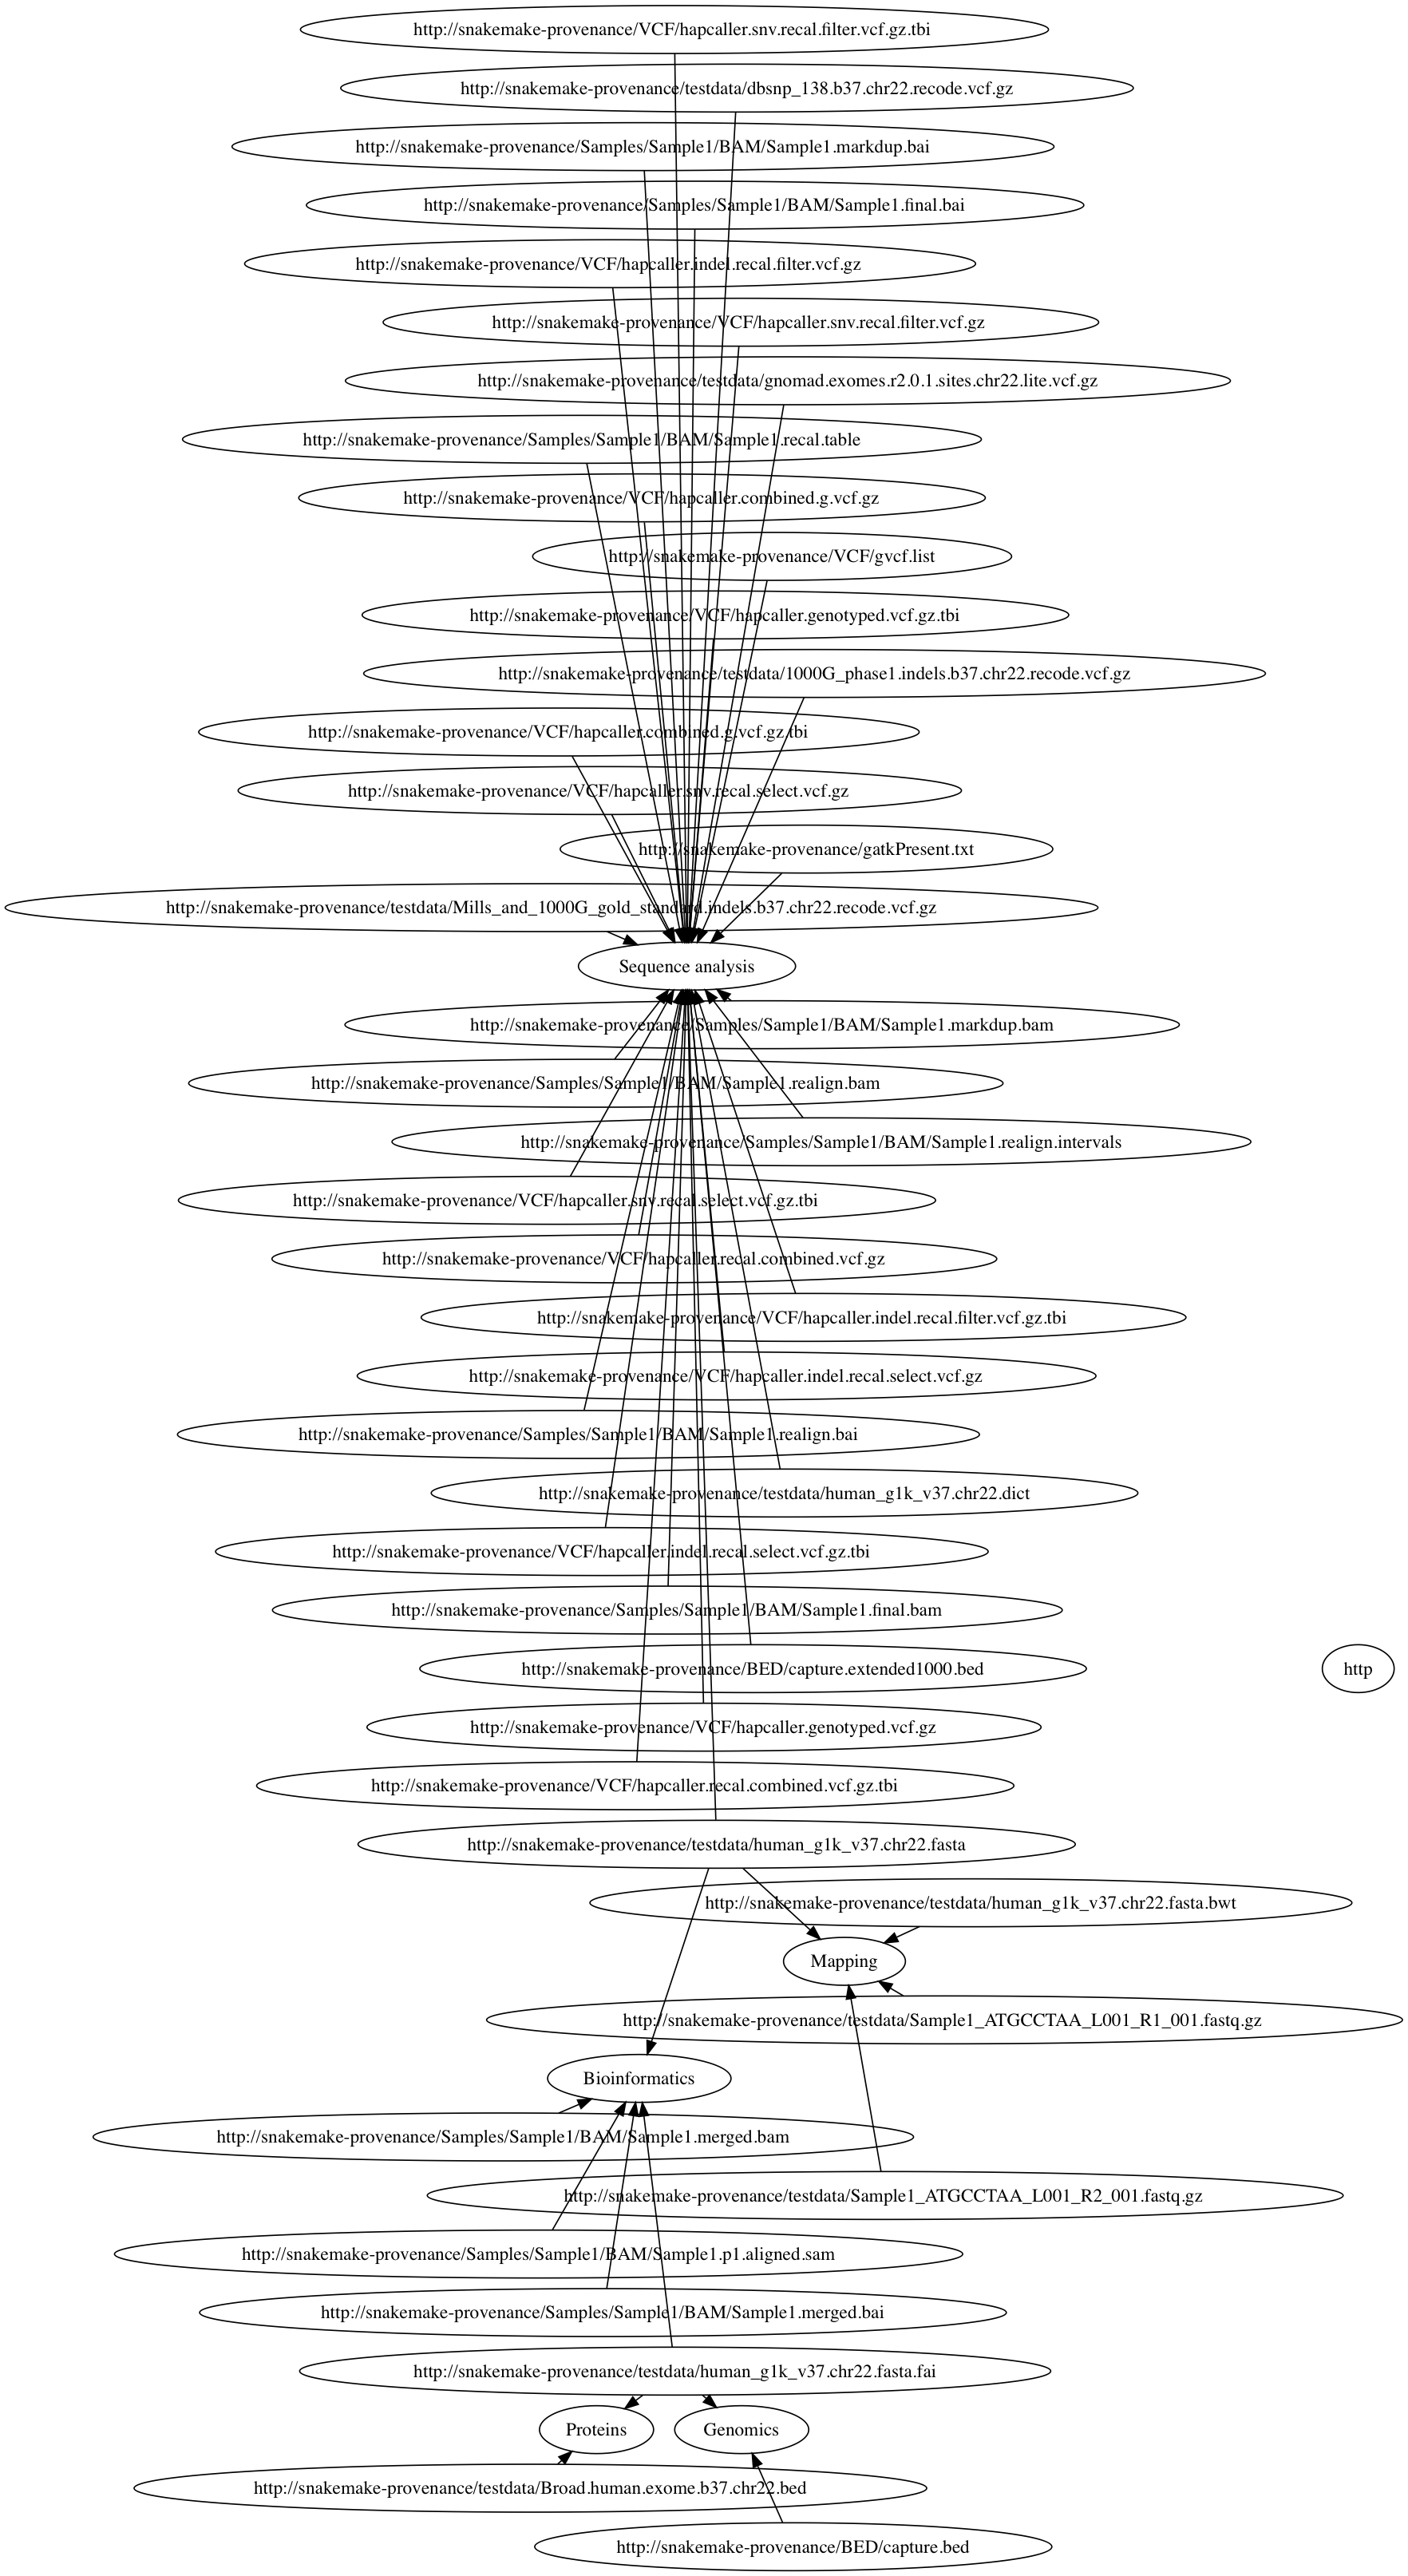

In [9]:
import networkx as nx
from nxpd import draw
G = nx.DiGraph()
G.graph['dpi'] = 120
G.graph['layout'] = 'neato'
G.graph['overlap'] = 'vpsc'
G.add_edges_from(edges)
draw(G, show='ipynb')